<a href="https://colab.research.google.com/github/kgpark88/energy-bigdata-analysis/blob/main/energy_usage_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 빌딩 에너지 사용량 예측 모델링
* 빌딩 에너지 효율화에 필수 기능인 에너지 사용량 예측 모델을 개발합니다.
* 시계열 데이터로 미래의 값을 예측하는 것은 판매량 예측, 주가 예측, 날씨예측 등 다양한 분야에 활용할 수 있습니다.

## 필요 라이브러리(패키지)
- Numpy : 다차원 배열 연산
- Pandas : 데이타 처리와 분석
- Matplotlib : 데이터를 차트나 플롯(Plot)으로 시각화
- Scikit Learn : 교육 및 실무를 위한 머신러닝 패키지
- TensorFlow : 구글에서 만든 오픈소스 딥러닝 프레임워크

## 데이터 파일 : e_usage_train.csv, e_usage_test.csv
- 데이터 설명 : ABC 빌딩의 15분 전기에너지 사용량 데이터
- e_usage_train.csv : 모델 학습(Train) 데이터,        70,000개
- e_usage_test.csv : 모델 성능 테스트(Test) 데이터, 35,040개
- 빌딩의 전기에너지 검침 주기가 15분으로,   
  1시간에는 4개의 데이터,
  하루에는 96개(4개x24시) 데이터,   
  1년 기간에는 35,040개(4개x24시x365일)의 데이터가 있습니다.

## 데이터 컬럼명
- b_name : 빌딩 이름
- daq_time : 데이터 수집 시간
- wday : 요일 구분
- day_type : 일 구분, 1 - 평일, 2 - 토요일, 3 - 일요일, 휴일
- temp : 온도( °C )
- rh : 상대습도(%)




## STEP 1. 라이브러리 import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## STEP 2. 시계열 데이터 처리

### csv 파일에서 Train 데이터를 로드합니다.

In [2]:
# df = pd.read_csv('e_usage_train.csv', header = 0, delimiter = ',')
df = pd.read_csv('https://raw.githubusercontent.com/kgpark88/energy-bigdata-analysis/main/e_usage_train.csv', header = 0, delimiter = ',')

### 데이터를 확인합니다.

In [3]:
df.head()

,b_name,daq_time,wday,day_type,hour,temp,rh,p_usage
0,ABC,2016-01-01 0:15,5,3,1,-2.5,99.0,229
1,ABC,2016-01-01 0:30,5,3,1,-2.5,99.0,231
2,ABC,2016-01-01 0:45,5,3,1,-2.5,99.0,231
3,ABC,2016-01-01 1:00,5,3,1,-3.1,100.0,226
4,ABC,2016-01-01 1:15,5,3,2,-3.1,100.0,229


In [4]:
df.tail()

,b_name,daq_time,wday,day_type,hour,temp,rh,p_usage
70171,ABC,2017-12-31 23:00,7,3,23,-1.6,42.0,278
70172,ABC,2017-12-31 23:15,7,3,24,-1.6,42.0,281
70173,ABC,2017-12-31 23:30,7,3,24,-1.6,42.0,292
70174,ABC,2017-12-31 23:45,7,3,24,-1.6,42.0,293
70175,ABC,2017-12-31 23:59,7,3,24,-1.6,42.0,283


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70176 entries, 0 to 70175
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   b_name    70176 non-null  object 
 1   daq_time  70176 non-null  object 
 2   wday      70176 non-null  int64  
 3   day_type  70176 non-null  int64  
 4   hour      70176 non-null  int64  
 5   temp      70176 non-null  float64
 6   rh        70176 non-null  float64
 7   p_usage   70176 non-null  int64  
dtypes: float64(2), int64(4), object(2)
memory usage: 4.3+ MB


In [6]:
df.describe()

,wday,day_type,hour,temp,rh,p_usage
count,70176.000000,70176.000000,70176.000000,70176.000000,70176.000000,70176.000000
mean,4.008208,1.455540,12.500000,13.118254,67.584975,322.534328
std,2.000681,0.748287,6.922236,11.044776,22.356921,62.353697
min,1.000000,1.000000,1.000000,-16.200000,11.000000,0.000000
25%,2.000000,1.000000,6.750000,3.500000,50.000000,283.000000
50%,4.000000,1.000000,12.500000,14.300000,67.000000,312.000000
75%,6.000000,2.000000,18.250000,22.600000,88.000000,355.000000
max,7.000000,3.000000,24.000000,36.000000,100.000000,531.000000


### 시퀀스 데이터 구성
- 속성 데이터가 한개인 일변량 시계열(Univariate time series) 데이터,
  또는 속성 데이터가 여러개인 다변량 시계열(Multivariate time series) 데이터를 입력으로 사용할 수 있습니다.
- 다양한 응용이 가능하도록 여러개의 속성을 입력데이터 사용 하겠습니다.
  
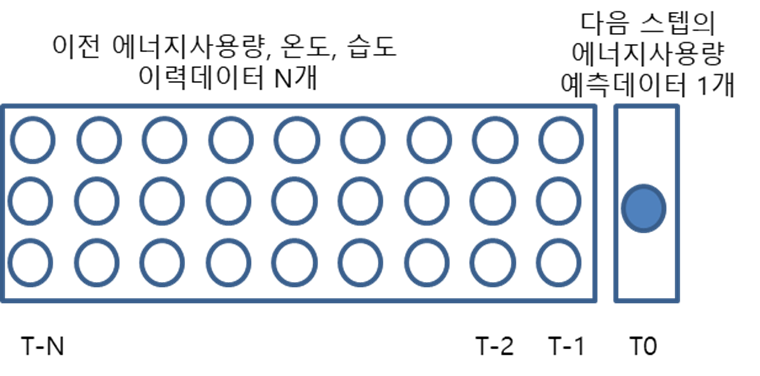

### 데이터셋을 입력시퀀스데이터와 타깃데이터로 분리하는 함수입니다.
- 시계열 데이터를 시퀀스 데이터로 변환
- 입력데이터는 시퀀스이고, 출력은 고정크기의 벡터나 스칼라인 다대일(many-to-one) 구조로 데이터 변환

In [7]:
def split_multivariate_data(dataset, target, start_index, end_index, hist_data_size, target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + hist_data_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-hist_data_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

### 입력시퀀스데이터, 타깃데이터, 예측데이터를 그래프에 출력하는 함수입니다.

In [8]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    n_steps = len(series)
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16, rotation=90)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)

### 전력사용량, 온도, 상대습도를 입력데이터(Feature)로 사용합니다.

In [9]:
features = ['p_usage', 'temp', 'rh']
features_data = df[features]
features_data.index = df['daq_time']
features_data.head()

,p_usage,temp,rh
daq_time,,,
2016-01-01 0:15,229,-2.5,99.0
2016-01-01 0:30,231,-2.5,99.0
2016-01-01 0:45,231,-2.5,99.0
2016-01-01 1:00,226,-3.1,100.0
2016-01-01 1:15,229,-3.1,100.0


### 시계열 데이터의 패턴을 확인합니다.

array([<Axes: xlabel='daq_time'>, <Axes: xlabel='daq_time'>,
       <Axes: xlabel='daq_time'>], dtype=object)

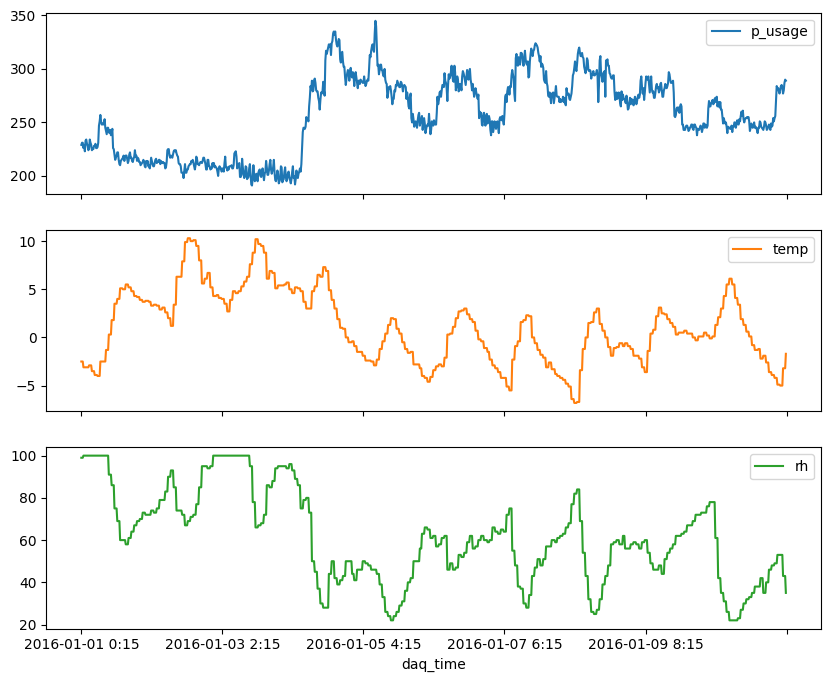

In [10]:
features_data[0:1000].plot(subplots=True, figsize=(10, 8))

In [11]:
dataset = features_data.values
dataset

array([[229. ,  -2.5,  99. ],
       [231. ,  -2.5,  99. ],
       [231. ,  -2.5,  99. ],
       ...,
       [292. ,  -1.6,  42. ],
       [293. ,  -1.6,  42. ],
       [283. ,  -1.6,  42. ]])

### 데이터셋의 피처(Feature)를 정규화(Scaling)합니다.

In [12]:
len(dataset)

70176

In [13]:
TRAIN_SPLIT = 60000
HISTORY_DATA_SIZE = 20
FUTURE_TARGET = 0
STEP = 1

In [14]:
scaler = MinMaxScaler()
dataset  = scaler.fit_transform(dataset)

### Train 데이터셋과 Validation 데이터셋을 만듭니다.

In [15]:
X = dataset
y = dataset[:,0]

X_train, y_train = split_multivariate_data(X, y,
                                           0, TRAIN_SPLIT,
                                           HISTORY_DATA_SIZE, FUTURE_TARGET,
                                           STEP, True)
X_valid, y_valid = split_multivariate_data(X, y,
                                           TRAIN_SPLIT, None,
                                           HISTORY_DATA_SIZE, FUTURE_TARGET,
                                           STEP, True)

#### split_multivariate_data 함수가 반환하는 내용입니다.

In [16]:
print ('Single window of past history : {}'.format(X_train[0].shape))

Single window of past history : (20, 3)


In [17]:
print ('입력 데이터')
print (X_train[0])
print ('타겟 데이터')
print (y_train[0])

입력 데이터
[[0.43126177 0.26245211 0.98876404]
 [0.43502825 0.26245211 0.98876404]
 [0.43502825 0.26245211 0.98876404]
 [0.42561205 0.25095785 1.        ]
 [0.43126177 0.25095785 1.        ]
 [0.41996234 0.25095785 1.        ]
 [0.43879473 0.25095785 1.        ]
 [0.44067797 0.25095785 1.        ]
 [0.43314501 0.25095785 1.        ]
 [0.42937853 0.25095785 1.        ]
 [0.42184557 0.25095785 1.        ]
 [0.42561205 0.25478927 1.        ]
 [0.44067797 0.25478927 1.        ]
 [0.43502825 0.25478927 1.        ]
 [0.43126177 0.25478927 1.        ]
 [0.42184557 0.24329502 1.        ]
 [0.42561205 0.24329502 1.        ]
 [0.42372881 0.24329502 1.        ]
 [0.42937853 0.24329502 1.        ]
 [0.42937853 0.23563218 1.        ]]
타겟 데이터
0.4331450094161958


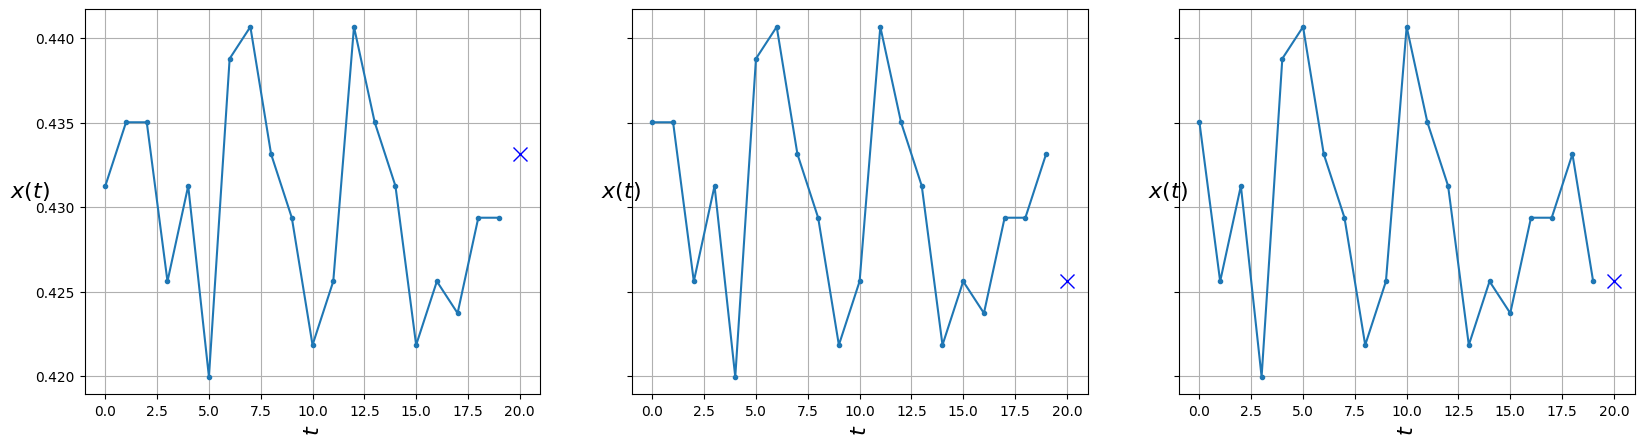

In [18]:
cols = 3
fig, axes = plt.subplots(nrows=1, ncols=cols, sharey=True, figsize=(20, 5))
for i in range(cols):
    plt.sca(axes[i])
    plot_series(X_train[i, :, 0], y_train[i])
plt.show()

## STEP 3. 딥러닝 모델 구현

- 데이터가 순차데이터(Sequence Data)인 시계열(Time Series) 이므로  
다양한 길이의 순차데이터 처리에 적합한 RNN 기반의 LSTM 모델을 사용합니다.  
- https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM  

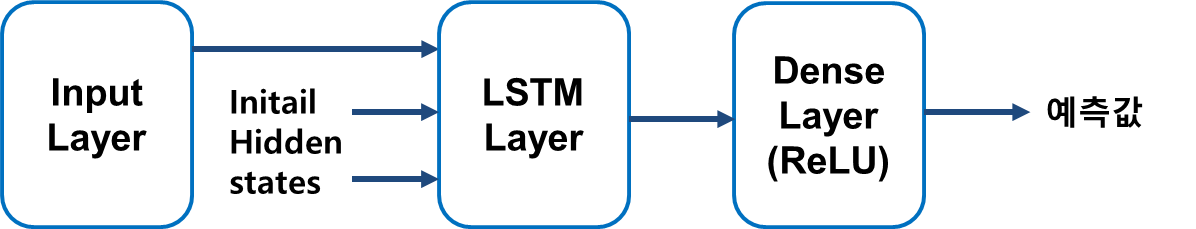
  
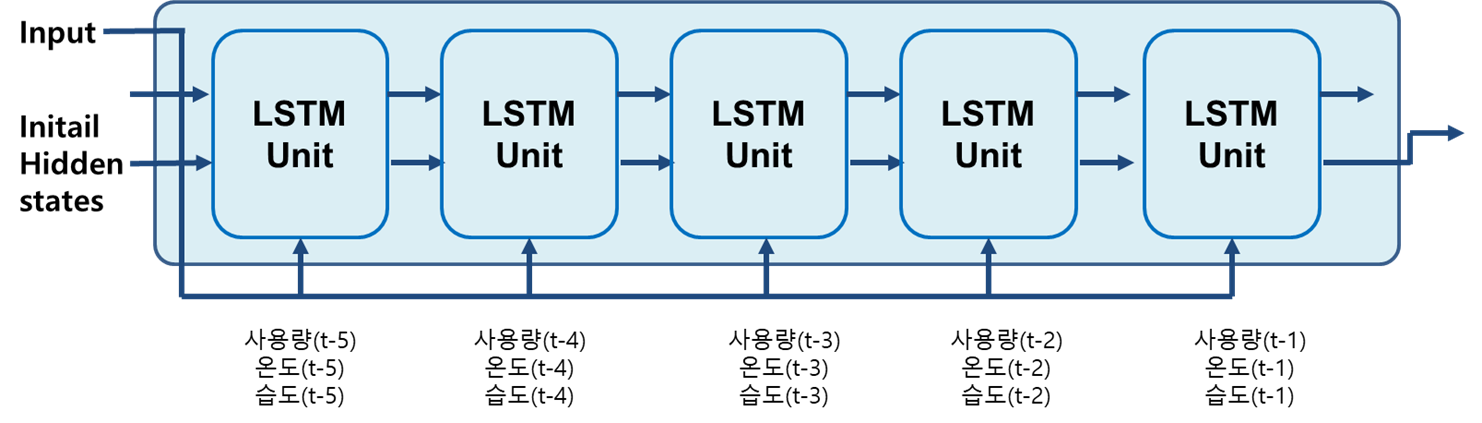

In [19]:
HIDDEN_SIZE = 10
DROP_OUT = 0.3

model = Sequential()
model.add(LSTM(HIDDEN_SIZE, input_shape=[20, 3], return_sequences=False))
model.add(Dropout(DROP_OUT))
model.add(Dense(1))

### 모델 구성 확인

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10)                560       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 571
Trainable params: 571
Non-trainable params: 0
_________________________________________________________________


### 초기 가중치 확인

In [21]:
hidden1 = model.layers[0]
hidden1.get_weights()

[array([[-0.22085385,  0.32159138,  0.2176469 , -0.22071616, -0.05196512,
          0.00669399, -0.03211904, -0.0539248 , -0.35376886,  0.12772834,
         -0.2837759 , -0.09386507,  0.13319695, -0.20101534, -0.03376958,
          0.13697428,  0.12972713,  0.14140552, -0.02545062,  0.06853467,
          0.35439032, -0.07624102, -0.31151313, -0.25490862,  0.33626157,
         -0.0080575 ,  0.27959543,  0.04657522, -0.19275016, -0.01196456,
         -0.01966405, -0.33250308, -0.30617183, -0.21900782, -0.14312027,
          0.22575355,  0.01525959,  0.12261772, -0.36668056,  0.33651078],
        [ 0.3515222 ,  0.01233816, -0.2558881 ,  0.3162114 , -0.30210423,
         -0.28301266,  0.13023508,  0.05816048,  0.07849282, -0.16102698,
         -0.14084497, -0.20323694, -0.02590749, -0.09790117, -0.33296877,
          0.13422167, -0.0679566 ,  0.1482634 ,  0.26352084, -0.16832925,
         -0.06661037,  0.314075  , -0.28511882,  0.25654733,  0.05404013,
         -0.02790937, -0.16547196,  0

### 모델 컴파일

In [22]:
model.compile(optimizer='adam', loss='mse')

### 모델 학습(Train) 조기종료, 체크포인트 설정

In [23]:
early_stop = EarlyStopping(monitor='val_loss', mode='min',
                    verbose=1, patience=5)
check_point = ModelCheckpoint('best_model.h5', verbose=1,
            monitor='val_loss', mode='min', save_best_only=True)

### 모델 학습(Train)
전력사용량 데이터는 일(Day) 단위 패턴이 있으므로 BATCH_SIZE를 96(15분*24시간=96)으로 해보겠습니다.

In [24]:
EPOCHS = 50
BATCH_SIZE=96

history = model.fit(x=X_train, y=y_train,
          epochs=EPOCHS,
          batch_size=BATCH_SIZE,
          verbose=1,
          validation_data=(X_valid, y_valid),
          callbacks=[early_stop, check_point])

Epoch 1/50
625/625 [==============================] - ETA: 0s - loss: 0.0347
Epoch 1: val_loss improved from inf to 0.00178, saving model to best_model.h5
625/625 [==============================] - 15s 6ms/step - loss: 0.0347 - val_loss: 0.0018
Epoch 2/50
623/625 [============================>.] - ETA: 0s - loss: 0.0094
Epoch 2: val_loss improved from 0.00178 to 0.00069, saving model to best_model.h5
625/625 [==============================] - 3s 5ms/step - loss: 0.0094 - val_loss: 6.9212e-04
Epoch 3/50
614/625 [============================>.] - ETA: 0s - loss: 0.0050
Epoch 3: val_loss improved from 0.00069 to 0.00056, saving model to best_model.h5
625/625 [==============================] - 3s 5ms/step - loss: 0.0050 - val_loss: 5.5728e-04
Epoch 4/50
622/625 [============================>.] - ETA: 0s - loss: 0.0027
Epoch 4: val_loss improved from 0.00056 to 0.00049, saving model to best_model.h5
625/625 [==============================] - 4s 6ms/step - loss: 0.0027 - val_loss: 4.8922e-04

### 모델의 Training Loss와 Validation Loss를 출력하는 함수입니다.

In [25]:
def plot_learning_curves(loss, val_loss):
    plt.figure(figsize=(12, 5))
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.axis([1, 10, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()

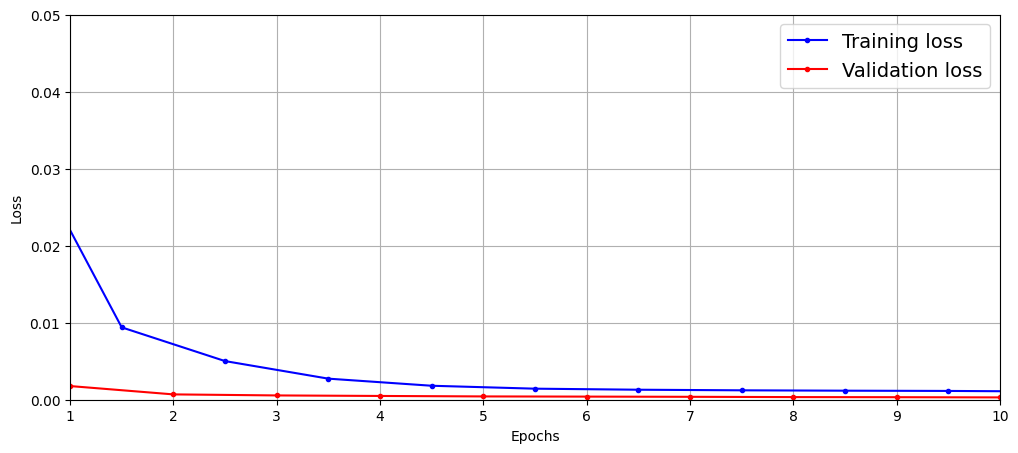

In [26]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])

### 모델 저장

In [27]:
model.save('my_model.h5')

## STEP 4. 딥러닝 모델 사용

### csv 파일에서 Test 데이터를 로드합니다.

In [28]:
# df = pd.read_csv('e_usage_test.csv', header = 0, delimiter = ',')
df = pd.read_csv('https://raw.githubusercontent.com/kgpark88/energy-bigdata-analysis/main/e_usage_test.csv', header = 0, delimiter = ',')

### 데이터를 확인합니다.

In [29]:
df.head()

,b_name,daq_time,wday,day_type,hour,temp,rh,p_usage
0,ABC,2018-01-01 0:15,1,3,1,-1.8,43,283
1,ABC,2018-01-01 0:30,1,3,1,-1.8,43,279
2,ABC,2018-01-01 0:45,1,3,1,-1.8,43,283
3,ABC,2018-01-01 1:00,1,3,1,-2.6,46,284
4,ABC,2018-01-01 1:15,1,3,2,-2.6,46,273


In [30]:
df.tail()

,b_name,daq_time,wday,day_type,hour,temp,rh,p_usage
35035,ABC,2018-12-31 23:00,1,1,23,-2.6,62,230
35036,ABC,2018-12-31 23:15,1,1,24,-2.6,62,252
35037,ABC,2018-12-31 23:30,1,1,24,-2.6,62,253
35038,ABC,2018-12-31 23:45,1,1,24,-2.6,62,253
35039,ABC,2018-12-31 23:59,1,1,24,-2.6,62,264


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   b_name    35040 non-null  object 
 1   daq_time  35040 non-null  object 
 2   wday      35040 non-null  int64  
 3   day_type  35040 non-null  int64  
 4   hour      35040 non-null  int64  
 5   temp      35040 non-null  float64
 6   rh        35040 non-null  int64  
 7   p_usage   35040 non-null  int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 2.1+ MB


### 전력사용량, 온도, 상대습도를 입력데이터(Feature)로 사용합니다.

In [32]:
features = ['p_usage', 'temp', 'rh']
features_data = df[features]
features_data.index = df['daq_time']
dataset = features_data.values
dataset

array([[283. ,  -1.8,  43. ],
       [279. ,  -1.8,  43. ],
       [283. ,  -1.8,  43. ],
       ...,
       [253. ,  -2.6,  62. ],
       [253. ,  -2.6,  62. ],
       [264. ,  -2.6,  62. ]])

### 데이터를 정규화(Scaling) 합니다.

In [33]:
scaled_dataset = scaler.transform(dataset)

In [34]:
X = scaled_dataset
y = scaled_dataset[:,0]

X_test, y_test = split_multivariate_data(X, y,
                                         0, None,
                                         HISTORY_DATA_SIZE, FUTURE_TARGET,
                                         STEP, True)

### 저장한 모델을 로드합니다.

In [35]:
model = load_model('my_model.h5')

### 테스트 데이터셋으로 모델 성능을 평가합니다.

In [36]:
model.evaluate(X_test, y_test)

1095/1095 [==============================] - 3s 3ms/step - loss: 5.6871e-04


0.0005687054945155978

### AI모델로 에너지 사용량을 예측합니다.

1/1 [==============================] - 0s 353ms/step


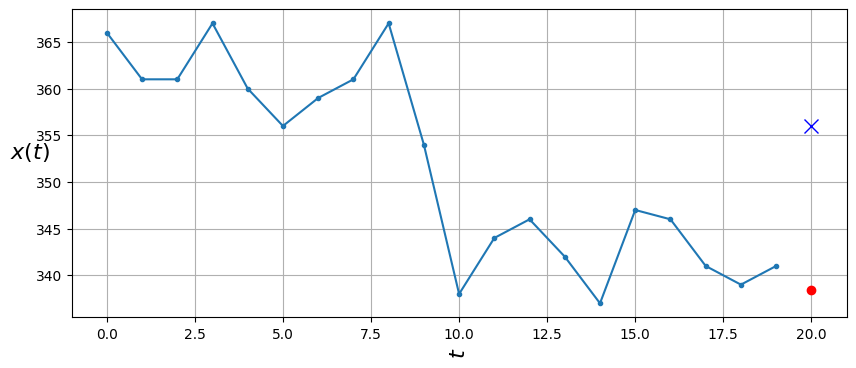

입력데이터 : [366. 361. 361. 367. 360. 356. 359. 361. 367. 354. 338. 344. 346. 342.
 337. 347. 346. 341. 339. 341.]
실제값 : 356.00
예측값 : 338.43
오차 : 17.57
오차율 : 4.94%
1/1 [==============================] - 0s 18ms/step


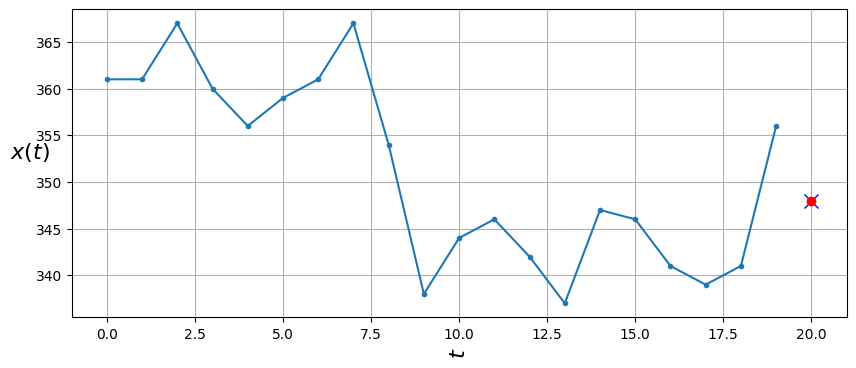

입력데이터 : [361. 361. 367. 360. 356. 359. 361. 367. 354. 338. 344. 346. 342. 337.
 347. 346. 341. 339. 341. 356.]
실제값 : 348.00
예측값 : 348.00
오차 : 0.00
오차율 : 0.00%
1/1 [==============================] - 0s 22ms/step


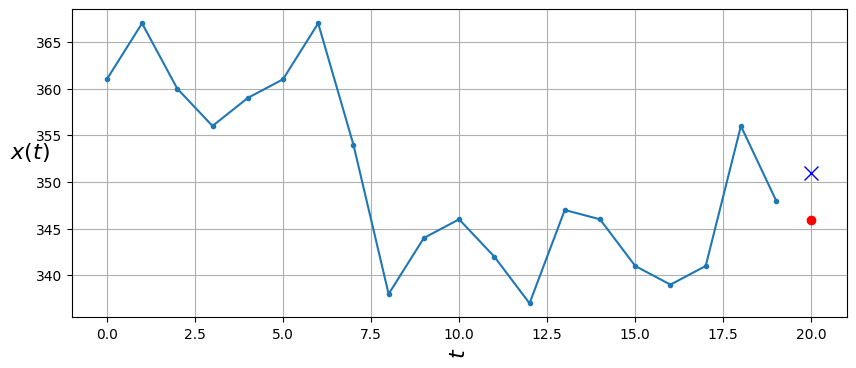

입력데이터 : [361. 367. 360. 356. 359. 361. 367. 354. 338. 344. 346. 342. 337. 347.
 346. 341. 339. 341. 356. 348.]
실제값 : 351.00
예측값 : 345.87
오차 : 5.13
오차율 : 1.46%
1/1 [==============================] - 0s 19ms/step


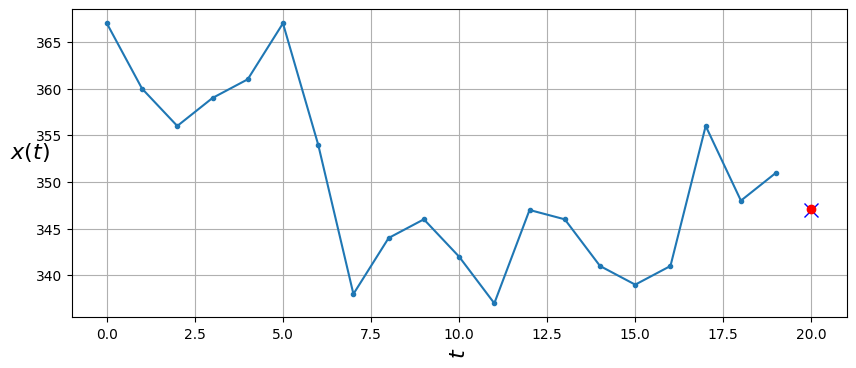

입력데이터 : [367. 360. 356. 359. 361. 367. 354. 338. 344. 346. 342. 337. 347. 346.
 341. 339. 341. 356. 348. 351.]
실제값 : 347.00
예측값 : 347.08
오차 : 0.08
오차율 : 0.02%
1/1 [==============================] - 0s 25ms/step


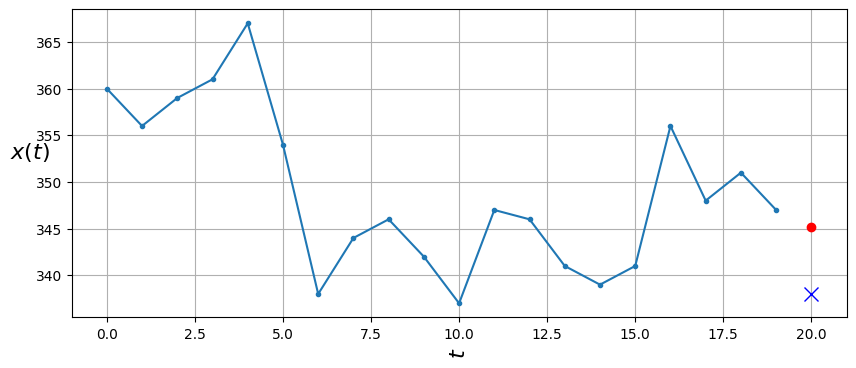

입력데이터 : [360. 356. 359. 361. 367. 354. 338. 344. 346. 342. 337. 347. 346. 341.
 339. 341. 356. 348. 351. 347.]
실제값 : 338.00
예측값 : 345.18
오차 : 7.18
오차율 : 2.12%
1/1 [==============================] - 0s 31ms/step


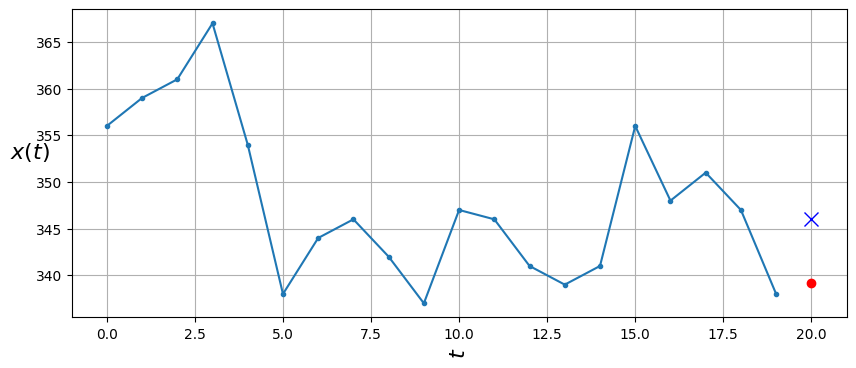

입력데이터 : [356. 359. 361. 367. 354. 338. 344. 346. 342. 337. 347. 346. 341. 339.
 341. 356. 348. 351. 347. 338.]
실제값 : 346.00
예측값 : 339.18
오차 : 6.82
오차율 : 1.97%
1/1 [==============================] - 0s 28ms/step


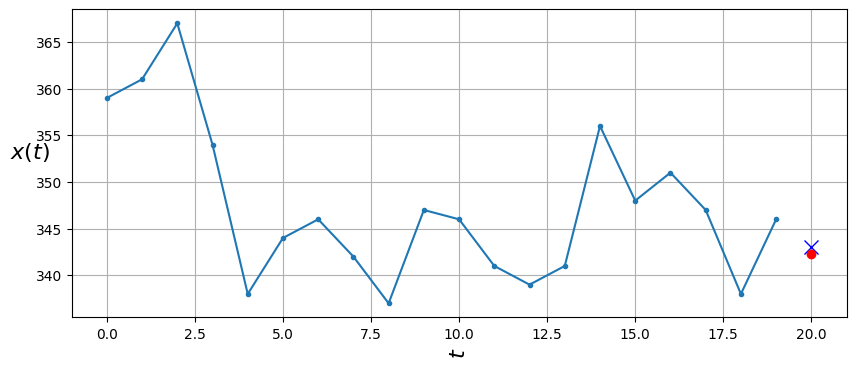

입력데이터 : [359. 361. 367. 354. 338. 344. 346. 342. 337. 347. 346. 341. 339. 341.
 356. 348. 351. 347. 338. 346.]
실제값 : 343.00
예측값 : 342.30
오차 : 0.70
오차율 : 0.20%
1/1 [==============================] - 0s 31ms/step


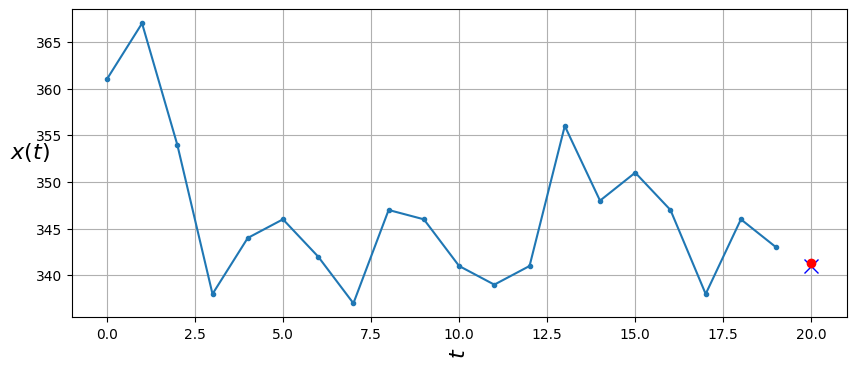

입력데이터 : [361. 367. 354. 338. 344. 346. 342. 337. 347. 346. 341. 339. 341. 356.
 348. 351. 347. 338. 346. 343.]
실제값 : 341.00
예측값 : 341.34
오차 : 0.34
오차율 : 0.10%
1/1 [==============================] - 0s 29ms/step


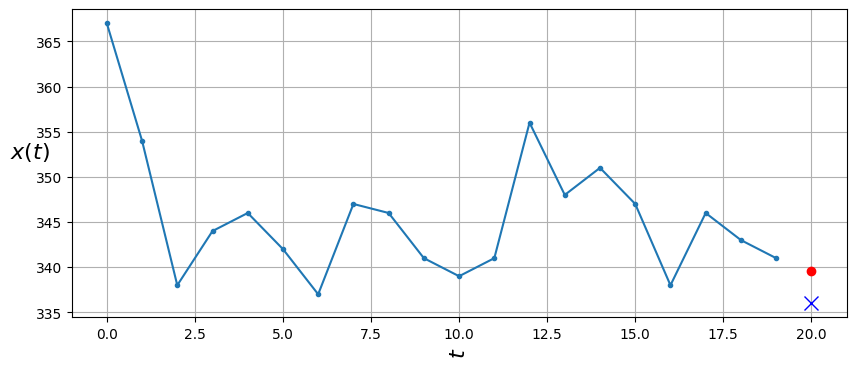

입력데이터 : [367. 354. 338. 344. 346. 342. 337. 347. 346. 341. 339. 341. 356. 348.
 351. 347. 338. 346. 343. 341.]
실제값 : 336.00
예측값 : 339.59
오차 : 3.59
오차율 : 1.07%
1/1 [==============================] - 0s 30ms/step


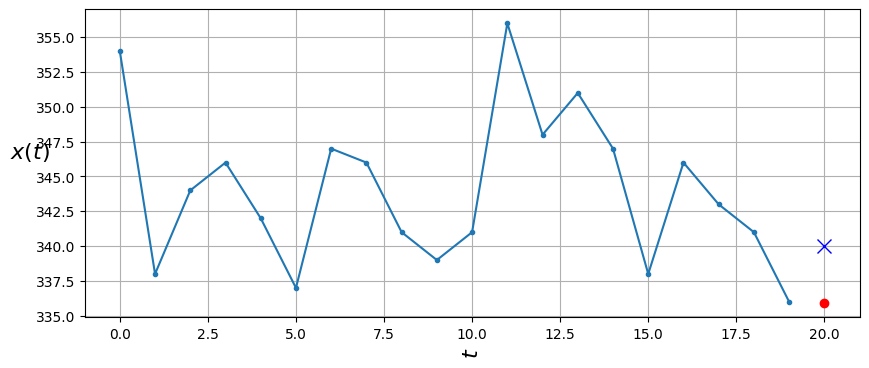

입력데이터 : [354. 338. 344. 346. 342. 337. 347. 346. 341. 339. 341. 356. 348. 351.
 347. 338. 346. 343. 341. 336.]
실제값 : 340.00
예측값 : 335.89
오차 : 4.11
오차율 : 1.21%


In [37]:
for TIME_STEP in range(1000,1010):
    p_usage_hist = scaler.inverse_transform(X_test[TIME_STEP])
    p_usage_hist = p_usage_hist[:, 0]

    p_usage_real  = dataset[TIME_STEP + HISTORY_DATA_SIZE][0]

    pred = model.predict(
        X_test[TIME_STEP].reshape(1, HISTORY_DATA_SIZE, -1))
    pred = pred[0][0]
    p_usage_pred = scaler.inverse_transform([[pred, 0, 0]])[0][0]

    error = abs(p_usage_pred - p_usage_real)
    error_rate = error/p_usage_real*100

    fig, axes = plt.subplots(nrows=1, ncols=1,
                             sharey=True, figsize=(10, 4))
    plot_series(p_usage_hist, p_usage_real, p_usage_pred)
    plt.show()

    print(f'입력데이터 : {p_usage_hist}')
    print(f'실제값 : {p_usage_real:.2f}')
    print(f'예측값 : {p_usage_pred:.2f}')
    print(f'오차 : {error:.2f}')
    print(f'오차율 : {error_rate:.2f}%')